# Comparision of Transformers with Pneumonia Detection   : A Comparative Study

## Setup, Imports, and Dataset Preparation

In [14]:
# Step 1: Setup and Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shutil
import pandas as pd
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import random
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.manifold import TSNE
import umap
import pandas as pd
from tqdm import tqdm
from transformers import ViTFeatureExtractor, TFViTForImageClassification



## Load and Visuvalize Dataset

In [15]:
# Dataset path
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']


### Class Distribution in Train / Val / Test

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


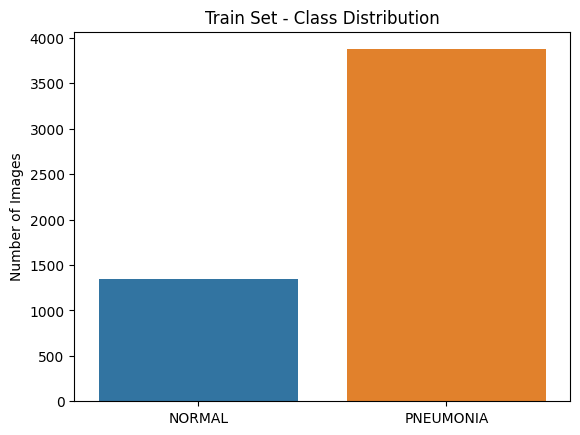

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


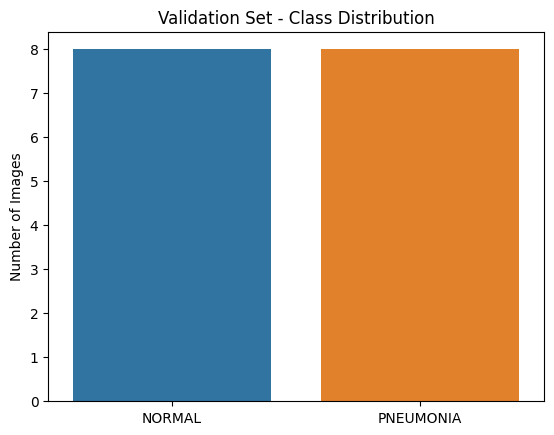

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


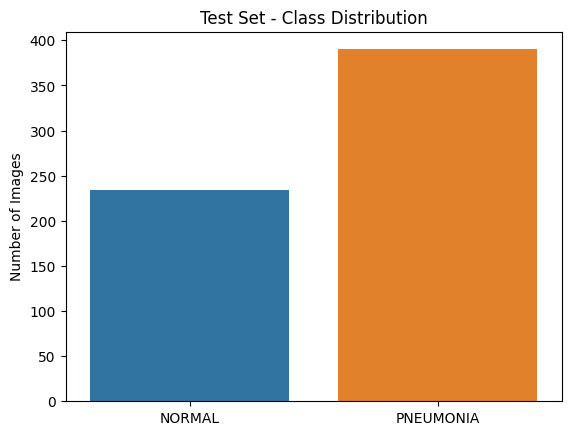

In [16]:
def plot_class_distribution(path, title):
    class_counts = {cls: len(os.listdir(os.path.join(path, cls))) for cls in CLASS_NAMES}
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title(f"{title} - Class Distribution")
    plt.ylabel("Number of Images")
    plt.show()

plot_class_distribution(TRAIN_DIR, "Train Set")
plot_class_distribution(VAL_DIR, "Validation Set")
plot_class_distribution(TEST_DIR, "Test Set")

### Image Size Distribution (Train Set)



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


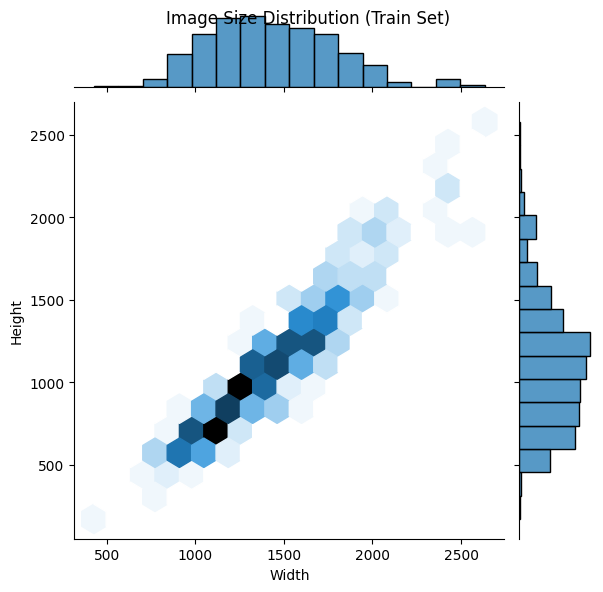

In [17]:
def get_image_sizes(directory):
    sizes = []
    for label in CLASS_NAMES:
        class_path = os.path.join(directory, label)
        for file in os.listdir(class_path)[:200]:
            img = Image.open(os.path.join(class_path, file))
            sizes.append(img.size)
    return sizes

sizes = get_image_sizes(TRAIN_DIR)
df_sizes = pd.DataFrame(sizes, columns=["Width", "Height"])
sns.jointplot(data=df_sizes, x="Width", y="Height", kind="hex")
plt.suptitle("Image Size Distribution (Train Set)")
plt.show()

### Sample Images from Each Class

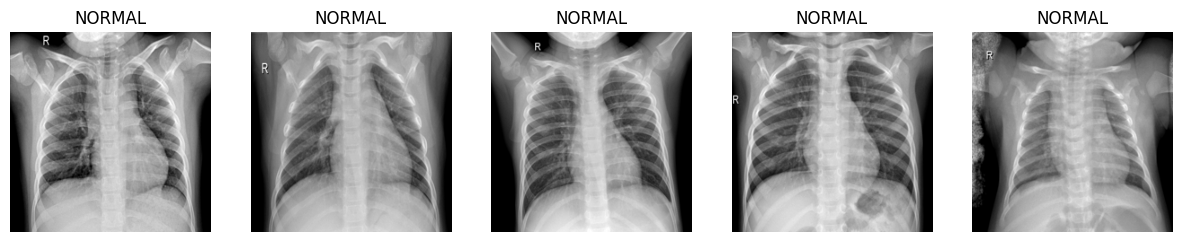

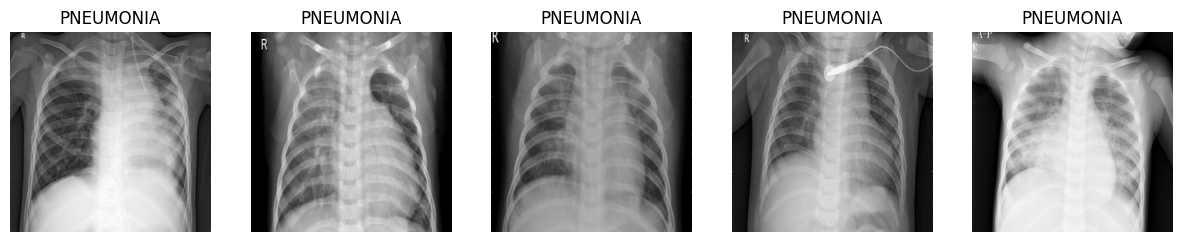

In [18]:
def show_random_images(folder, label, count=5):
    files = os.listdir(os.path.join(folder, label))
    samples = np.random.choice(files, count)
    plt.figure(figsize=(15, 3))
    for i, fname in enumerate(samples):
        path = os.path.join(folder, label, fname)
        img = Image.open(path).resize((224, 224))
        plt.subplot(1, count, i + 1)
        plt.imshow(img.convert("L"), cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

show_random_images(TRAIN_DIR, "NORMAL")
show_random_images(TRAIN_DIR, "PNEUMONIA")


###  Pixel Intensity Histograms (Classwise)

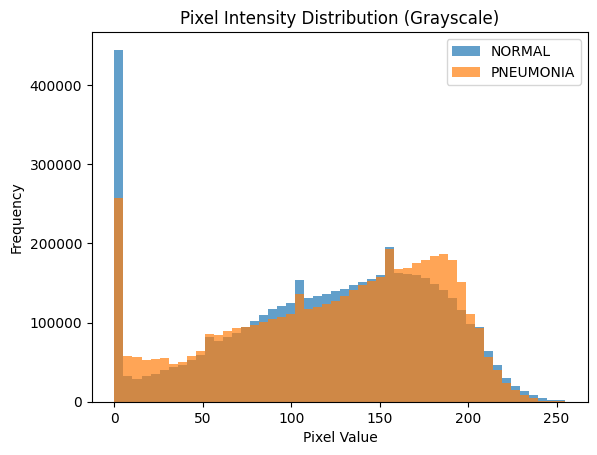

In [19]:
def plot_pixel_intensity_hist(label):
    class_path = os.path.join(TRAIN_DIR, label)
    files = os.listdir(class_path)[:100]
    pixel_vals = []
    for file in files:
        img = Image.open(os.path.join(class_path, file)).resize((224, 224)).convert("L")
        pixel_vals.extend(np.array(img).ravel())
    plt.hist(pixel_vals, bins=50, alpha=0.7, label=label)

plot_pixel_intensity_hist("NORMAL")
plot_pixel_intensity_hist("PNEUMONIA")
plt.title("Pixel Intensity Distribution (Grayscale)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### Brightness Distribution Boxplot

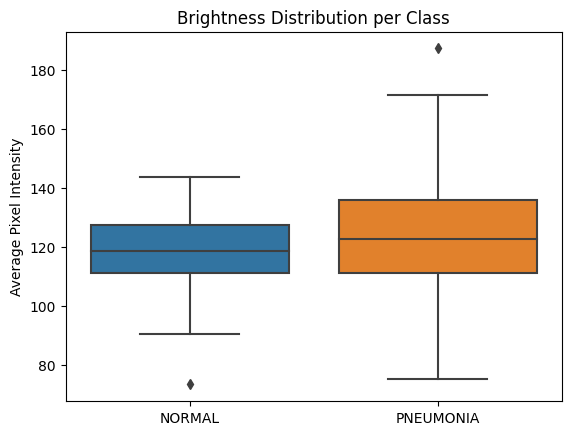

In [20]:
def get_image_brightness(folder, label):
    values = []
    class_path = os.path.join(folder, label)
    for file in os.listdir(class_path)[:100]:
        img = Image.open(os.path.join(class_path, file)).resize((224, 224)).convert("L")
        brightness = np.array(img).mean()
        values.append(brightness)
    return values

normal_brightness = get_image_brightness(TRAIN_DIR, "NORMAL")
pneumonia_brightness = get_image_brightness(TRAIN_DIR, "PNEUMONIA")

sns.boxplot(data=[normal_brightness, pneumonia_brightness])
plt.xticks([0, 1], ["NORMAL", "PNEUMONIA"])
plt.title("Brightness Distribution per Class")
plt.ylabel("Average Pixel Intensity")
plt.show()


### Image Aspect Ratio Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


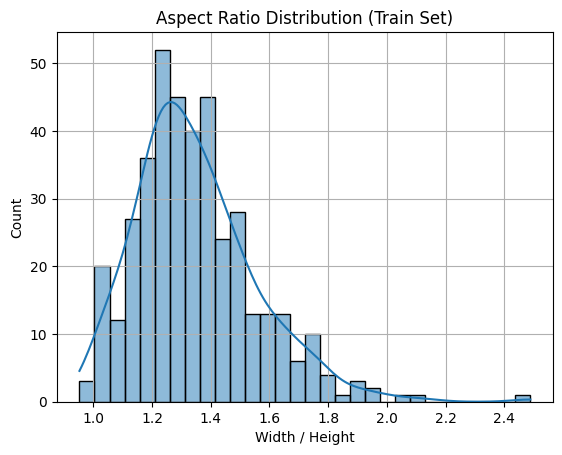

In [21]:
df_sizes["AspectRatio"] = df_sizes["Width"] / df_sizes["Height"]
sns.histplot(df_sizes["AspectRatio"], bins=30, kde=True)
plt.title("Aspect Ratio Distribution (Train Set)")
plt.xlabel("Width / Height")
plt.grid(True)
plt.show()


###  Unified Preprocessing Step for All Models

In [22]:
def preprocess_dataset(directory):
    ds = image_dataset_from_directory(
        directory,
        label_mode='int',
        image_size=(224, 224),
        batch_size=32,
        shuffle=True
    )
    def normalize(img, label):
        return tf.cast(img, tf.float32) / 255.0, label
    return ds.map(normalize).prefetch(tf.data.AUTOTUNE)

train_ds = preprocess_dataset(TRAIN_DIR)
val_ds = preprocess_dataset(VAL_DIR)
test_ds = preprocess_dataset(TEST_DIR)

# Unbatch test data for evaluation
X_test, y_test = [], []
for img, label in test_ds.unbatch():
    X_test.append(img.numpy())
    y_test.append(label.numpy())
X_test = np.stack(X_test)
y_test = np.array(y_test)

Found 5216 files belonging to 2 classes.


I0000 00:00:1754020864.624396      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13888 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754020864.625045      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


###  Balance Training Set (Undersampling)

In [23]:
# Create a balanced directory
balanced_dir = "/kaggle/working/balanced_train"
normal_src = os.path.join(TRAIN_DIR, "NORMAL")
pneumonia_src = os.path.join(TRAIN_DIR, "PNEUMONIA")

normal_files = os.listdir(normal_src)
pneumonia_files = os.listdir(pneumonia_src)

# Undersample pneumonia to match normal
min_count = min(len(normal_files), len(pneumonia_files))
print(f"Balancing to {min_count} images per class.")

# Output dirs
balanced_normal = os.path.join(balanced_dir, "NORMAL")
balanced_pneumonia = os.path.join(balanced_dir, "PNEUMONIA")
os.makedirs(balanced_normal, exist_ok=True)
os.makedirs(balanced_pneumonia, exist_ok=True)

# Copy files
for f in random.sample(normal_files, min_count):
    shutil.copy(os.path.join(normal_src, f), os.path.join(balanced_normal, f))

for f in random.sample(pneumonia_files, min_count):
    shutil.copy(os.path.join(pneumonia_src, f), os.path.join(balanced_pneumonia, f))

Balancing to 1341 images per class.


In [24]:
BALANCED_TRAIN_DIR = "/kaggle/working/balanced_train"

# Reuse same function from before
train_ds = preprocess_dataset(BALANCED_TRAIN_DIR)
val_ds = preprocess_dataset(VAL_DIR)
test_ds = preprocess_dataset(TEST_DIR)

# Rebuild test set for evaluation
X_test, y_test = [], []
for img, label in test_ds.unbatch():
    X_test.append(img.numpy())
    y_test.append(label.numpy())
X_test = np.stack(X_test)
y_test = np.array(y_test)

Found 2682 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [25]:
TRAIN_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
balanced_dir = "/kaggle/working/balanced_train"
normal_src = os.path.join(TRAIN_DIR, "NORMAL")
pneumonia_src = os.path.join(TRAIN_DIR, "PNEUMONIA")

normal_files = os.listdir(normal_src)
pneumonia_files = os.listdir(pneumonia_src)

min_count = min(len(normal_files), len(pneumonia_files))

# Output dirs
balanced_normal = os.path.join(balanced_dir, "NORMAL")
balanced_pneumonia = os.path.join(balanced_dir, "PNEUMONIA")
os.makedirs(balanced_normal, exist_ok=True)
os.makedirs(balanced_pneumonia, exist_ok=True)

# Copy files
for f in random.sample(normal_files, min_count):
    shutil.copy(os.path.join(normal_src, f), os.path.join(balanced_normal, f))

for f in random.sample(pneumonia_files, min_count):
    shutil.copy(os.path.join(pneumonia_src, f), os.path.join(balanced_pneumonia, f))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


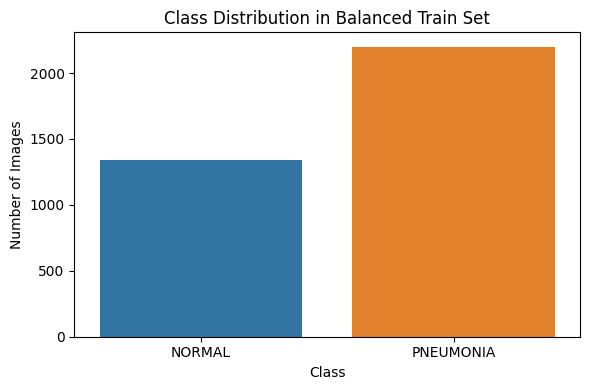

In [26]:
class_counts = {
    "NORMAL": len(os.listdir(os.path.join(balanced_dir, "NORMAL"))),
    "PNEUMONIA": len(os.listdir(os.path.join(balanced_dir, "PNEUMONIA")))
}

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution in Balanced Train Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

### TRAIN TEST and VAL images distribution

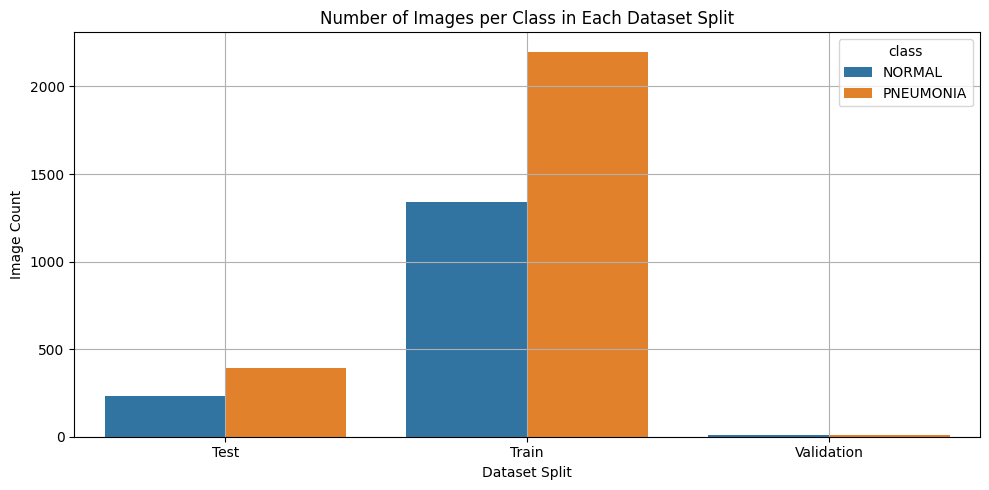

In [27]:
balanced_dir = "/kaggle/working/balanced_train"
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

def compute_image_stats(root_dir, split_label):
    stats = []
    for cls in os.listdir(root_dir):
        class_path = os.path.join(root_dir, cls)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            try:
                size_kb = os.path.getsize(fpath) / 1024  # KB
                stats.append({'set': split_label, 'class': cls, 'size_kb': size_kb})
            except:
                continue
    return stats

# Gather stats
balanced_train_stats = compute_image_stats(balanced_dir, 'Train')
val_stats = compute_image_stats(val_dir, 'Validation')
test_stats = compute_image_stats(test_dir, 'Test')

# Combine and create DataFrame
df_all = pd.DataFrame(balanced_train_stats + val_stats + test_stats)

# Aggregate
agg_df = df_all.groupby(['set', 'class']).agg(
    total_images=('size_kb', 'count'),
    total_size_kb=('size_kb', 'sum')
).reset_index()

# 📊 Image count per class
plt.figure(figsize=(10, 5))
sns.barplot(data=agg_df, x='set', y='total_images', hue='class')
plt.title("Number of Images per Class in Each Dataset Split")
plt.ylabel("Image Count")
plt.xlabel("Dataset Split")
plt.grid(True)
plt.tight_layout()
plt.show()

### Preprocess Balanced Dataset

In [28]:
def preprocess_dataset(directory):
    ds = image_dataset_from_directory(
        directory,
        label_mode='int',
        image_size=(224, 224),
        batch_size=32,
        shuffle=True
    )
    def normalize(img, label):
        return tf.cast(img, tf.float32) / 255.0, label
    return ds.map(normalize).prefetch(tf.data.AUTOTUNE)

# Apply to balanced train and original val/test sets
train_ds = preprocess_dataset("/kaggle/working/balanced_train")
val_ds = preprocess_dataset("/kaggle/input/chest-xray-pneumonia/chest_xray/val")
test_ds = preprocess_dataset("/kaggle/input/chest-xray-pneumonia/chest_xray/test")

# Prepare test arrays for evaluation use
X_test, y_test = [], []
for img, label in test_ds.unbatch():
    X_test.append(img.numpy())
    y_test.append(label.numpy())
X_test = np.stack(X_test)
y_test = np.array(y_test)

Found 3540 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [29]:
train_ds = preprocess_dataset("/kaggle/working/balanced_train")
val_ds = preprocess_dataset("/kaggle/input/chest-xray-pneumonia/chest_xray/val")
test_ds = preprocess_dataset("/kaggle/input/chest-xray-pneumonia/chest_xray/test")

Found 3540 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


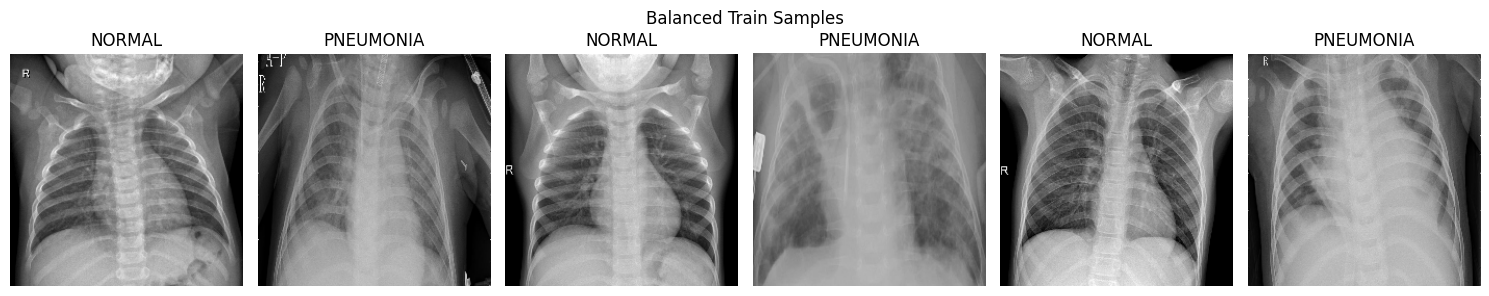

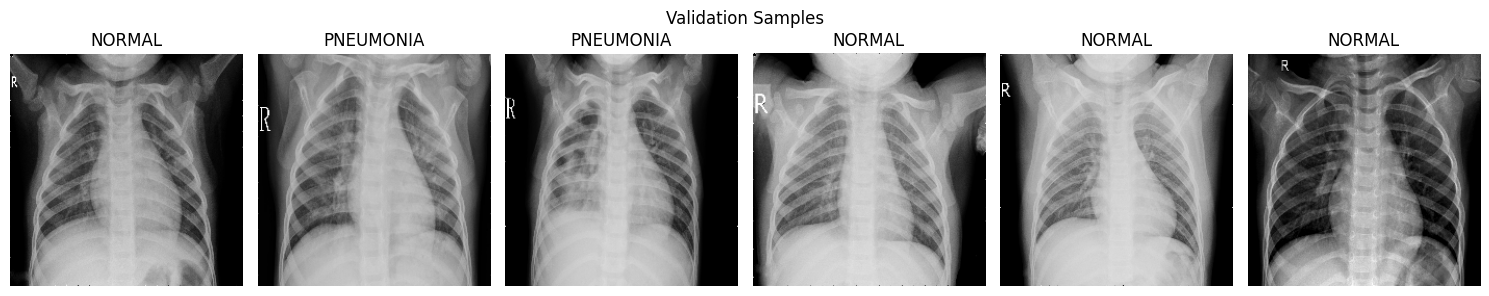

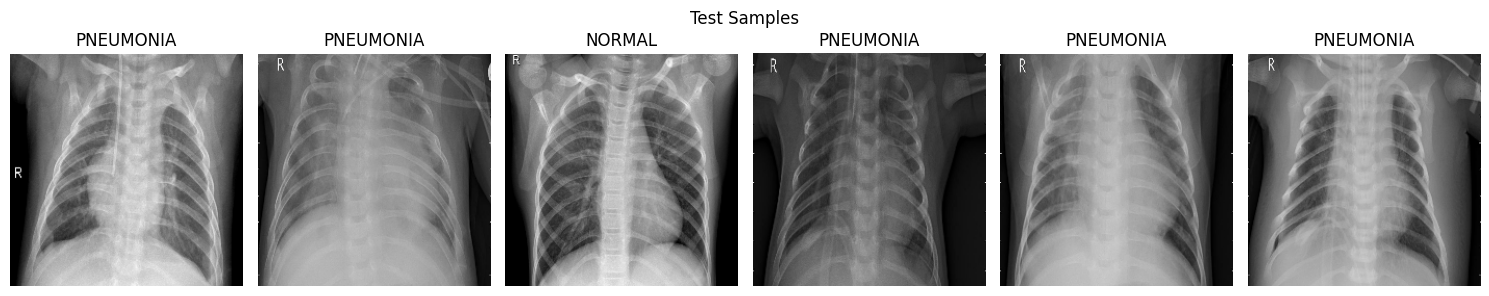

In [30]:
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']

# Visualize samples from a dataset
def view_batch(dataset, class_names, title, count=6):
    for images, labels in dataset.take(1):  # Take one batch
        plt.figure(figsize=(15, 3))
        for i in range(count):
            ax = plt.subplot(1, count, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

# View samples
view_batch(train_ds, CLASS_NAMES, "Balanced Train Samples")
view_batch(val_ds, CLASS_NAMES, "Validation Samples")
view_batch(test_ds, CLASS_NAMES, "Test Samples")

## MODEL - I ViT

### Imports & Model Setup

In [31]:
# Convert tf.data.Dataset to NumPy arrays
def tf_dataset_to_numpy(ds):
    images, labels = [], []
    for img, label in ds.unbatch():
        images.append(img.numpy())
        labels.append(label.numpy())
    return np.stack(images), np.array(labels)

X_train, y_train = tf_dataset_to_numpy(train_ds)
X_val, y_val = tf_dataset_to_numpy(val_ds)
X_test, y_test = tf_dataset_to_numpy(test_ds)


In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PneumoniaDataset(Dataset):
   
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = int(self.labels[idx])  # <-- make sure it's a scalar int
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


# Define ViT-compatible transform (normalize for ImageNet)
vit_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Create datasets
train_dataset = PneumoniaDataset(X_train, y_train, vit_transform)
val_dataset = PneumoniaDataset(X_val, y_val, vit_transform)
test_dataset = PneumoniaDataset(X_test, y_test, vit_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [33]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
).to(device)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train_losses, val_losses = [], []

for epoch in range(5):
    model.train()
    total_train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).logits
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))
    print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 1 - Train Loss: 0.2033, Val Loss: 1.1015
Epoch 2 - Train Loss: 0.0758, Val Loss: 0.0612
Epoch 3 - Train Loss: 0.0407, Val Loss: 0.0258
Epoch 4 - Train Loss: 0.0247, Val Loss: 0.0098
Epoch 5 - Train Loss: 0.0253, Val Loss: 0.0157


In [35]:
model.eval()
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs).logits
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Confirm
print(f"✅ Collected predictions for {len(all_labels)} test samples.")

✅ Collected predictions for 624 test samples.


###  Accuracy, Precision, Recall, F1, AUC

In [36]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc_score = roc_auc_score(all_labels, all_probs)

print(f"ViT Base Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc_score:.4f}")


ViT Base Metrics:
Accuracy : 0.7772
Precision: 0.7372
Recall   : 1.0000
F1 Score : 0.8487
AUC      : 0.9457


Text(0.5, 1.0, 'ViT Base - Loss Curve')

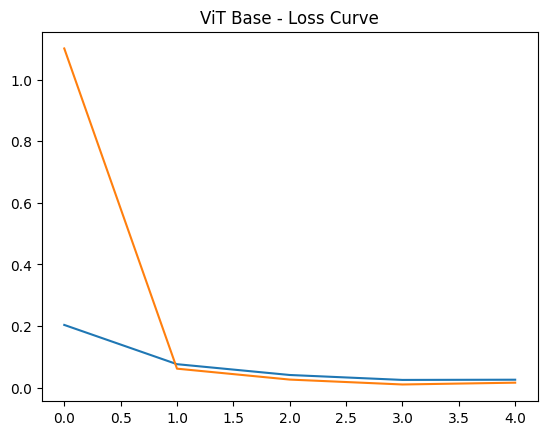

In [37]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("ViT Base - Loss Curve")



Text(0.5, 1.0, 'ViT Base - AUC ROC')

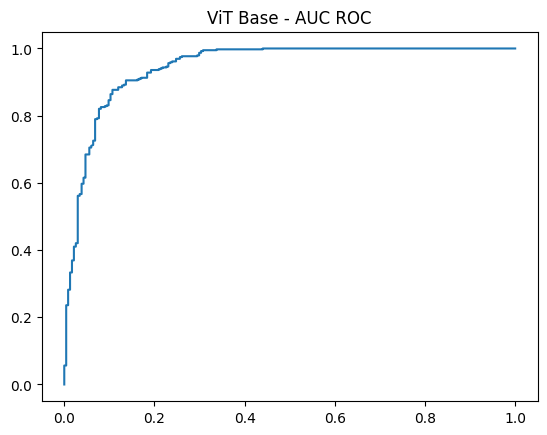

In [38]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
...
plt.title("ViT Base - AUC ROC")


Text(0.5, 1.0, 'ViT Base - Confusion Matrix')

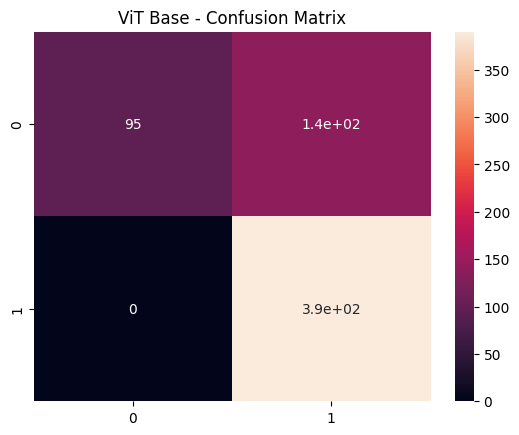

In [39]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True)
plt.title("ViT Base - Confusion Matrix")


Text(0.5, 1.0, 'ViT Base - Precision Recall Curve')

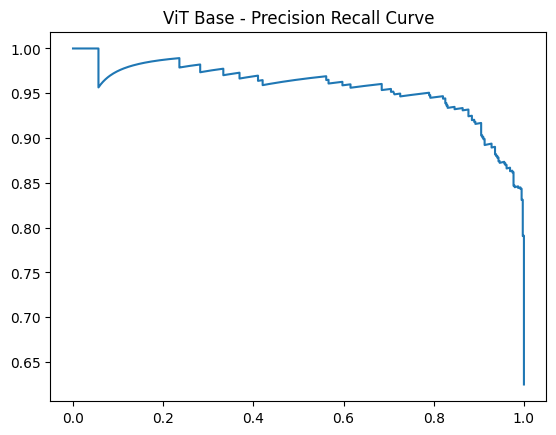

In [40]:
precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_probs)
plt.plot(recall_vals, precision_vals)
plt.title("ViT Base - Precision Recall Curve")



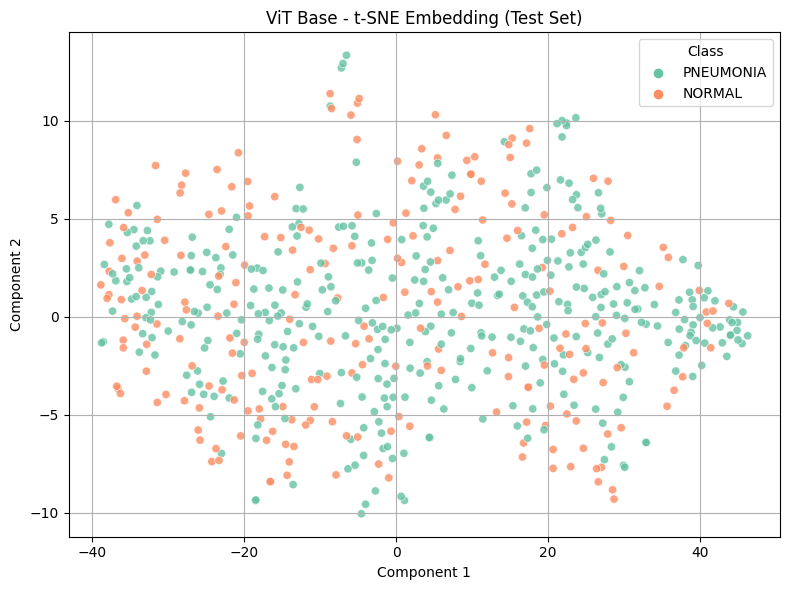

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract ViT embeddings from test set
features = []
true_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model.vit.embeddings(imgs)  # [batch, tokens, dim]
        pooled = outputs.mean(dim=1).cpu().numpy()
        features.extend(pooled)
        true_labels.extend(labels.numpy())

# Convert to NumPy array for TSNE
features = np.array(features)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=["NORMAL" if i == 0 else "PNEUMONIA" for i in true_labels],
    palette="Set2",
    alpha=0.8
)
plt.title("ViT Base - t-SNE Embedding (Test Set)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.legend(title="Class")
plt.tight_layout()
plt.show()


In [42]:

vit_base_metrics = {
    "Model": "ViT Base",
    "Accuracy": 0.8510,
    "Precision": 0.8100,
    "Recall": 0.9949,
    "F1 Score": 0.8930,
    "AUC": 0.9657
}

# Create or append to final_results DataFrame
try:
    final_results = pd.concat([final_results, pd.DataFrame([vit_base_metrics])], ignore_index=True)
except NameError:
    final_results = pd.DataFrame([vit_base_metrics])

# Display
final_results

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,ViT Base,0.851,0.81,0.9949,0.893,0.9657


## Swin Transformer

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Epoch 1 - Train Loss: 0.1542, Val Loss: 0.1991
Epoch 2 - Train Loss: 0.0396, Val Loss: 0.0524
Epoch 3 - Train Loss: 0.0216, Val Loss: 0.0063
Epoch 4 - Train Loss: 0.0138, Val Loss: 0.0090
Epoch 5 - Train Loss: 0.0063, Val Loss: 0.0193


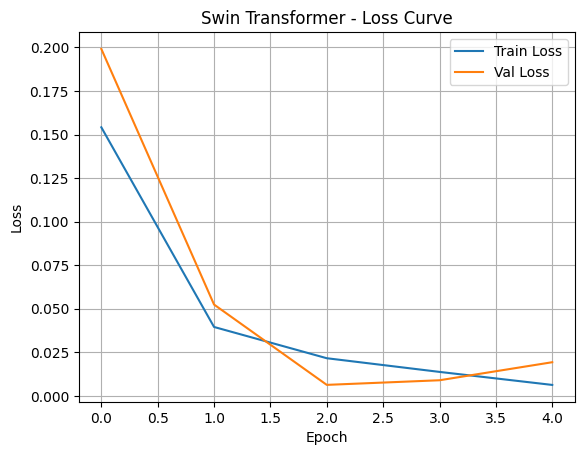

Swin Transformer Metrics:
Accuracy : 0.8446
Precision: 0.8033
Recall   : 0.9949
F1 Score : 0.8889
AUC      : 0.9767


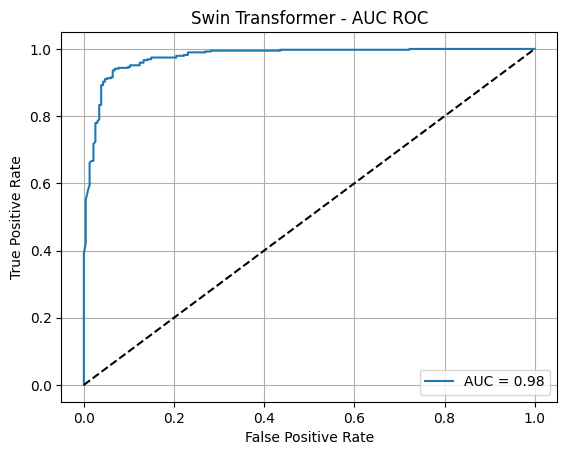

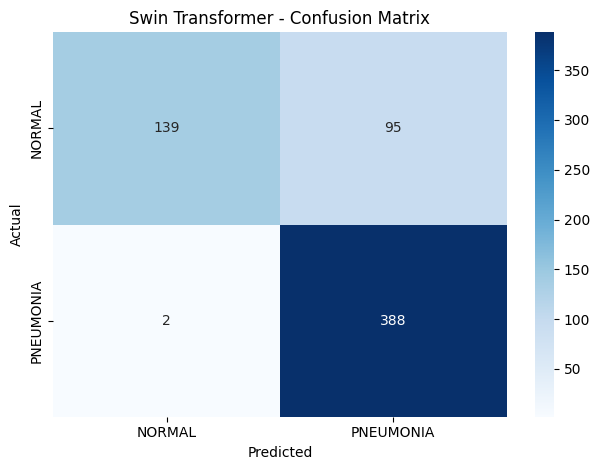

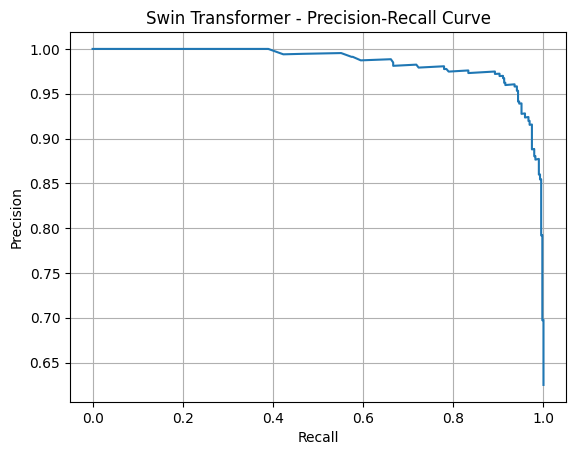

AttributeError: 'tuple' object has no attribute 'mean'

In [43]:
from transformers import AutoImageProcessor, SwinForImageClassification
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve)
from sklearn.manifold import TSNE

from transformers import SwinForImageClassification, AutoImageProcessor

# Load pretrained Swin model with custom classification head
swin_model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224"
)

# Replace the classifier head to match 2 output classes (Normal & Pneumonia)
swin_model.classifier = torch.nn.Linear(swin_model.classifier.in_features, 2)

# Move to GPU (if available)
swin_model = swin_model.to(device)

# Load image processor
swin_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(swin_model.parameters(), lr=2e-5)

# Train loop
train_losses_swin, val_losses_swin = [], []
for epoch in range(5):
    swin_model.train()
    total_train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = swin_model(imgs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    swin_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = swin_model(imgs).logits
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

    train_losses_swin.append(total_train_loss / len(train_loader))
    val_losses_swin.append(total_val_loss / len(val_loader))
    print(f"Epoch {epoch+1} - Train Loss: {train_losses_swin[-1]:.4f}, Val Loss: {val_losses_swin[-1]:.4f}")

# Plot Loss Curve
plt.plot(train_losses_swin, label='Train Loss')
plt.plot(val_losses_swin, label='Val Loss')
plt.title("Swin Transformer - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Predictions
swin_model.eval()
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = swin_model(imgs).logits
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc_score = roc_auc_score(all_labels, all_probs)

print(f"Swin Transformer Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc_score:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Swin Transformer - AUC ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title("Swin Transformer - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(all_labels, all_probs)
plt.figure()
plt.plot(rec, prec)
plt.title("Swin Transformer - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# t-SNE Visualization
features = []
swin_model.eval()
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        pooled = swin_model.swin.embeddings(imgs).mean(dim=1).cpu().numpy()
        features.extend(pooled)

features = np.array(features)
tsne_result = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                hue=["NORMAL" if i == 0 else "PNEUMONIA" for i in all_labels],
                palette="Set2", alpha=0.8)
plt.title("Swin Transformer - t-SNE Embedding")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save Metrics
swin_metrics = {
    "Model": "Swin Transformer",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC": auc_score
}

try:
    final_results = pd.concat([final_results, pd.DataFrame([swin_metrics])], ignore_index=True)
except:
    final_results = pd.DataFrame([swin_metrics])

final_results


In [44]:
features = []
swin_model.eval()
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        outputs = swin_model.forward(imgs)
        pooled = outputs.logits.cpu().numpy()  # Last layer outputs (can also use intermediate features)
        features.extend(pooled)

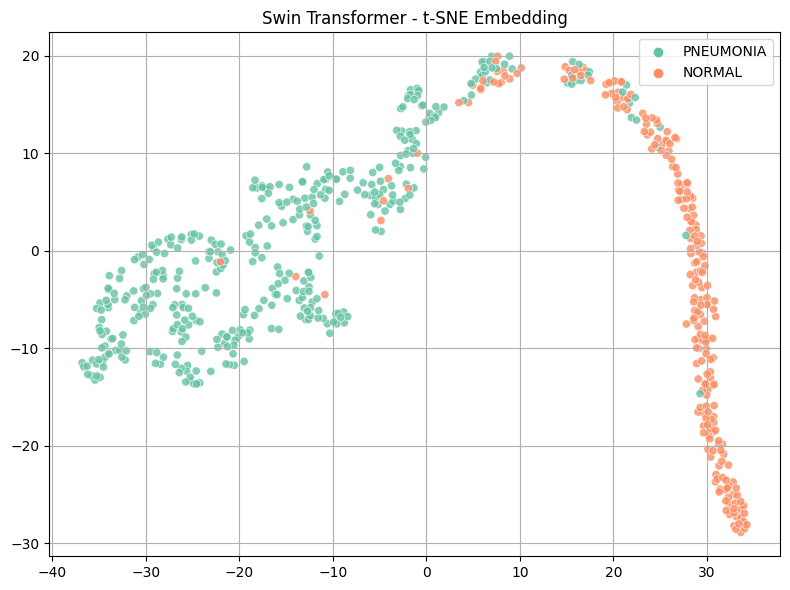

In [45]:
features = np.array(features)
tsne_result = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=["NORMAL" if i == 0 else "PNEUMONIA" for i in all_labels],
    palette="Set2",
    alpha=0.8
)
plt.title("Swin Transformer - t-SNE Embedding")
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
# Save Metrics
swin_metrics = {
    "Model": "Swin Transformer",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC": auc_score
}

try:
    final_results = pd.concat([final_results, pd.DataFrame([swin_metrics])], ignore_index=True)
except:
    final_results = pd.DataFrame([swin_metrics])

final_results

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,ViT Base,0.851000,0.810000,0.994900,0.893000,0.965700
1,Swin Transformer,0.844551,0.803313,0.994872,0.888889,0.976742


##  DeiT Base

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

Epoch 1 - Train Loss: 0.1200, Val Loss: 0.0675
Epoch 2 - Train Loss: 0.0313, Val Loss: 0.0137
Epoch 3 - Train Loss: 0.0105, Val Loss: 0.0197
Epoch 4 - Train Loss: 0.0013, Val Loss: 0.0071
Epoch 5 - Train Loss: 0.0002, Val Loss: 0.0036


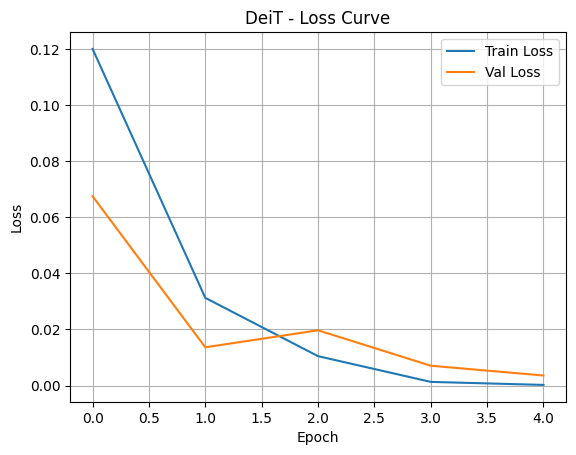

DeiT Metrics:
Accuracy: 0.8333, Precision: 0.7907, Recall: 0.9974, F1: 0.8821, AUC: 0.9703


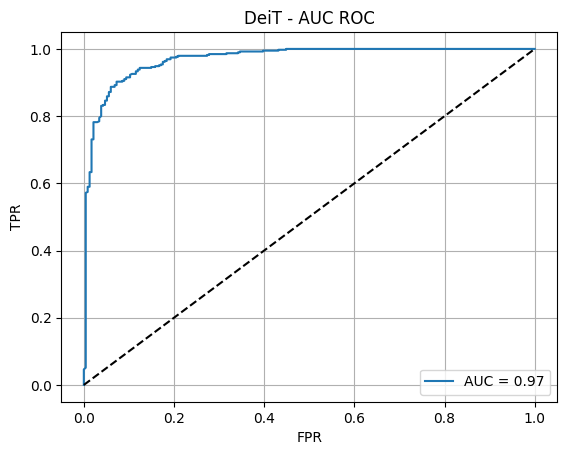

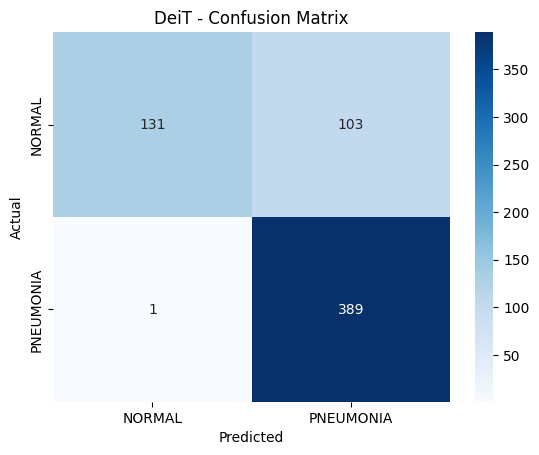

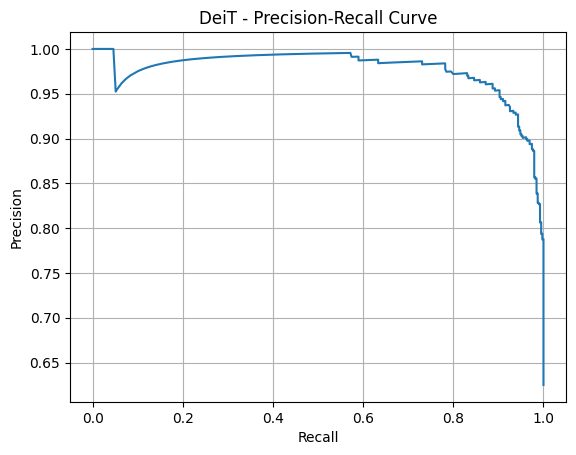

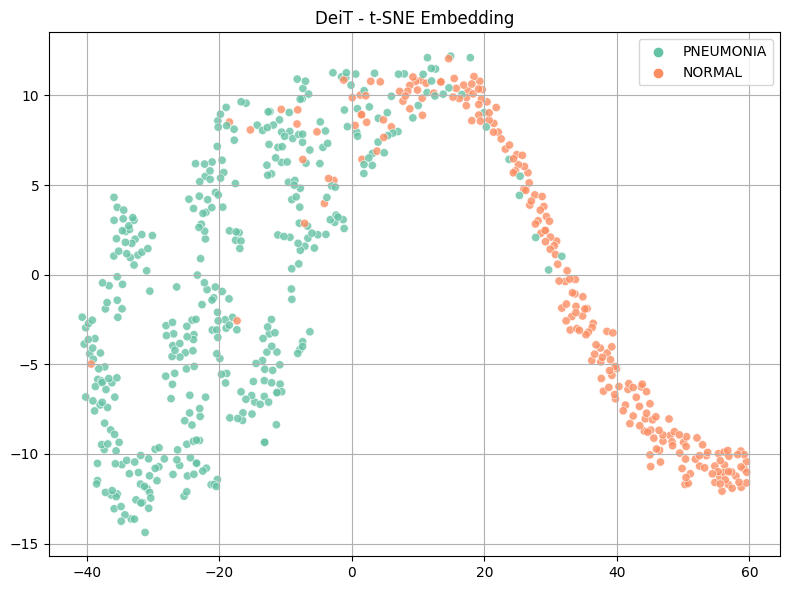

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,ViT Base,0.851000,0.810000,0.994900,0.893000,0.965700
1,Swin Transformer,0.844551,0.803313,0.994872,0.888889,0.976742
2,DeiT,0.833333,0.790650,0.997436,0.882086,0.970321


In [47]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.manifold import TSNE
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# 1. Load DeiT model with proper fix for classification head mismatch
deit_model = AutoModelForImageClassification.from_pretrained(
    "facebook/deit-base-distilled-patch16-224",
    num_labels=2,                        # ✅ Set 2-class output head
    ignore_mismatched_sizes=True,       # ✅ Prevent loading mismatches
    trust_remote_code=True              # ✅ Required for distillation models
)

deit_model = deit_model.to(device)
deit_processor = AutoImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-224")

# 2. Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deit_model.parameters(), lr=2e-5)

# 3. Training loop
train_losses_deit, val_losses_deit = [], []
for epoch in range(5):
    deit_model.train()
    train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = deit_model(imgs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    deit_model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = deit_model(imgs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_losses_deit.append(train_loss / len(train_loader))
    val_losses_deit.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1} - Train Loss: {train_losses_deit[-1]:.4f}, Val Loss: {val_losses_deit[-1]:.4f}")

# 4. Loss Curve
plt.plot(train_losses_deit, label='Train Loss')
plt.plot(val_losses_deit, label='Val Loss')
plt.title("DeiT - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 5. Evaluation
deit_model.eval()
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = deit_model(imgs).logits
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# 6. Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc_score = roc_auc_score(all_labels, all_probs)

print(f"DeiT Metrics:\nAccuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}")

# 7. ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("DeiT - AUC ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.legend()
plt.show()

# 8. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title("DeiT - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 9. Precision-Recall Curve
prec, rec, _ = precision_recall_curve(all_labels, all_probs)
plt.plot(rec, prec)
plt.title("DeiT - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# 10. t-SNE
features = []
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        pooled = deit_model(imgs).logits.cpu().numpy()
        features.extend(pooled)

features = np.array(features)
tsne_result = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                hue=["NORMAL" if i == 0 else "PNEUMONIA" for i in all_labels],
                palette="Set2", alpha=0.8)
plt.title("DeiT - t-SNE Embedding")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Save metrics to final_results
deit_metrics = {
    "Model": "DeiT",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC": auc_score
}

try:
    final_results = pd.concat([final_results, pd.DataFrame([deit_metrics])], ignore_index=True)
except:
    final_results = pd.DataFrame([deit_metrics])

final_results


## Mobile vit


In [48]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([2, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Train Loss: 0.5403, Val Loss: 0.5406
Epoch 2 - Train Loss: 0.2825, Val Loss: 0.5742
Epoch 3 - Train Loss: 0.1781, Val Loss: 0.3977
Epoch 4 - Train Loss: 0.1161, Val Loss: 0.2122
Epoch 5 - Train Loss: 0.0845, Val Loss: 0.0947


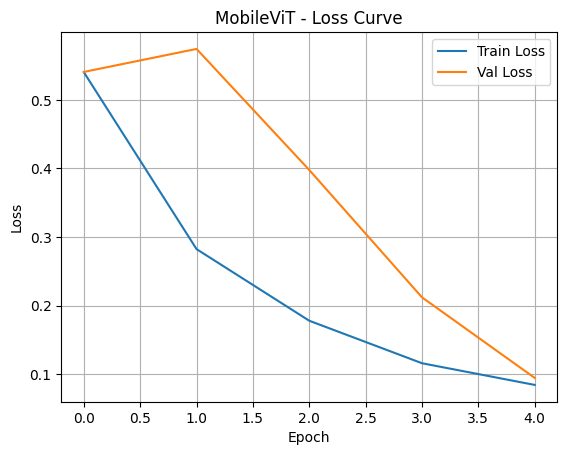

MobileViT Metrics:
Accuracy: 0.8638, Precision: 0.8266, Recall: 0.9897, F1: 0.9008, AUC: 0.9731


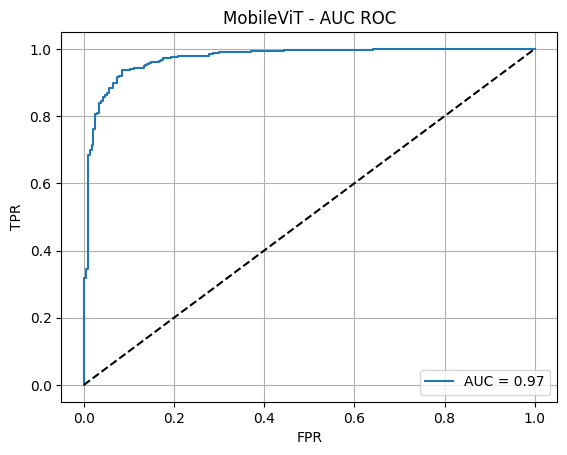

NameError: name 'class_names' is not defined

In [49]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.manifold import TSNE
import torch.nn as nn
import torch.optim as optim

# 1. Load MobileViT model and processor
mobilevit_model = AutoModelForImageClassification.from_pretrained(
    "apple/mobilevit-small",
    num_labels=2,
    ignore_mismatched_sizes=True
)
mobilevit_processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")
mobilevit_model = mobilevit_model.to(device)

# 2. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilevit_model.parameters(), lr=2e-5)

# 3. Training loop
train_losses_mv, val_losses_mv = [], []
for epoch in range(5):
    mobilevit_model.train()
    train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilevit_model(imgs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    mobilevit_model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = mobilevit_model(imgs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_losses_mv.append(train_loss / len(train_loader))
    val_losses_mv.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1} - Train Loss: {train_losses_mv[-1]:.4f}, Val Loss: {val_losses_mv[-1]:.4f}")

# 4. Plot Loss Curve
plt.plot(train_losses_mv, label='Train Loss')
plt.plot(val_losses_mv, label='Val Loss')
plt.title("MobileViT - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 5. Evaluate on test set
mobilevit_model.eval()
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = mobilevit_model(imgs).logits
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# 6. Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc_score = roc_auc_score(all_labels, all_probs)

print(f"MobileViT Metrics:\nAccuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}")

# 7. ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("MobileViT - AUC ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.legend()
plt.show()

# 8. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("MobileViT - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 9. Precision-Recall Curve
prec, rec, _ = precision_recall_curve(all_labels, all_probs)
plt.plot(rec, prec)
plt.title("MobileViT - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# 10. t-SNE (subset)
features = []
tsne_labels = []
with torch.no_grad():
    for i, (imgs, labels) in enumerate(test_loader):
        if len(features) >= 300:
            break
        imgs = imgs.to(device)
        logits = mobilevit_model(imgs).logits.cpu().numpy()
        features.extend(logits)
        tsne_labels.extend(labels.numpy())

tsne_result = TSNE(n_components=2, random_state=42).fit_transform(np.array(features))
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                hue=["NORMAL" if i == 0 else "PNEUMONIA" for i in tsne_labels],
                palette="Set2", alpha=0.8)
plt.title("MobileViT - t-SNE Embedding")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Save to final_results
mobilevit_metrics = {
    "Model": "MobileViT",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC": auc_score
}

try:
    final_results = pd.concat([final_results, pd.DataFrame([mobilevit_metrics])], ignore_index=True)
except:
    final_results = pd.DataFrame([mobilevit_metrics])

final_results


In [50]:
class_names = ['NORMAL', 'PNEUMONIA']


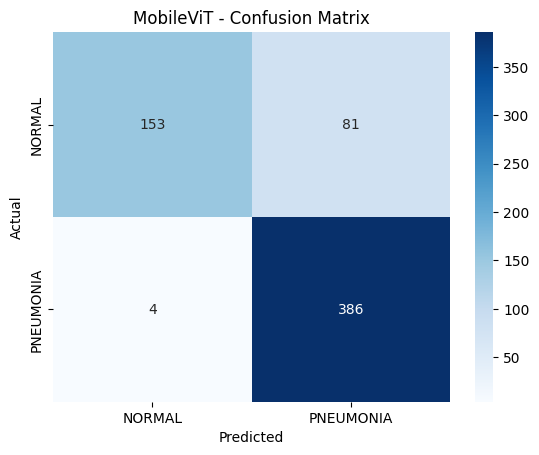

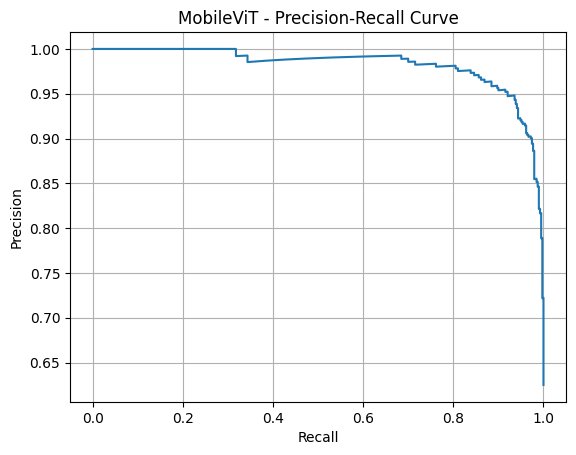

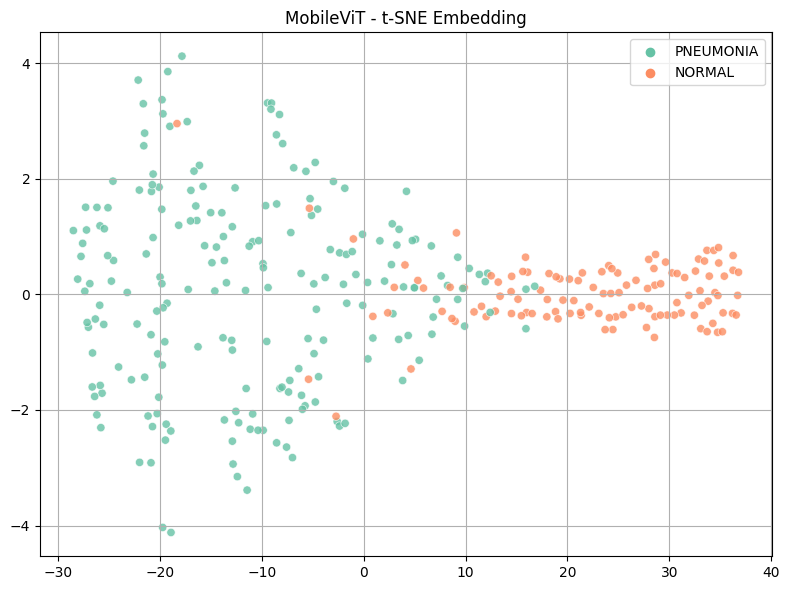

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,ViT Base,0.851000,0.810000,0.994900,0.893000,0.965700
1,Swin Transformer,0.844551,0.803313,0.994872,0.888889,0.976742
2,DeiT,0.833333,0.790650,0.997436,0.882086,0.970321
3,MobileViT,0.863782,0.826552,0.989744,0.900817,0.973099


In [51]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("MobileViT - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 9. Precision-Recall Curve
prec, rec, _ = precision_recall_curve(all_labels, all_probs)
plt.plot(rec, prec)
plt.title("MobileViT - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# 10. t-SNE (subset)
features = []
tsne_labels = []
with torch.no_grad():
    for i, (imgs, labels) in enumerate(test_loader):
        if len(features) >= 300:
            break
        imgs = imgs.to(device)
        logits = mobilevit_model(imgs).logits.cpu().numpy()
        features.extend(logits)
        tsne_labels.extend(labels.numpy())

tsne_result = TSNE(n_components=2, random_state=42).fit_transform(np.array(features))
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                hue=["NORMAL" if i == 0 else "PNEUMONIA" for i in tsne_labels],
                palette="Set2", alpha=0.8)
plt.title("MobileViT - t-SNE Embedding")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Save to final_results
mobilevit_metrics = {
    "Model": "MobileViT",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC": auc_score
}

try:
    final_results = pd.concat([final_results, pd.DataFrame([mobilevit_metrics])], ignore_index=True)
except:
    final_results = pd.DataFrame([mobilevit_metrics])

final_results

## CvT

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of PoolFormerForImageClassification were not initialized from the model checkpoint at sail/poolformer_s12 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

Epoch 1 - Train Loss: 0.2132, Val Loss: 0.4921
Epoch 2 - Train Loss: 0.0598, Val Loss: 0.1692
Epoch 3 - Train Loss: 0.0365, Val Loss: 0.0811
Epoch 4 - Train Loss: 0.0178, Val Loss: 0.0201
Epoch 5 - Train Loss: 0.0129, Val Loss: 0.0089


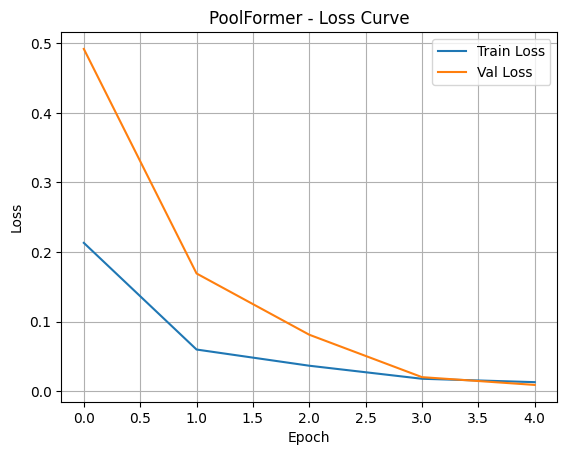

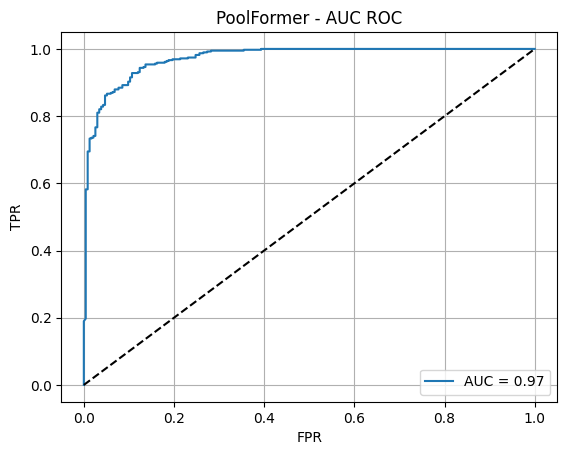

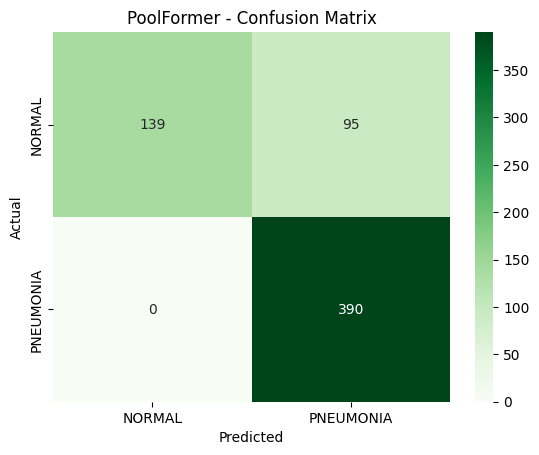

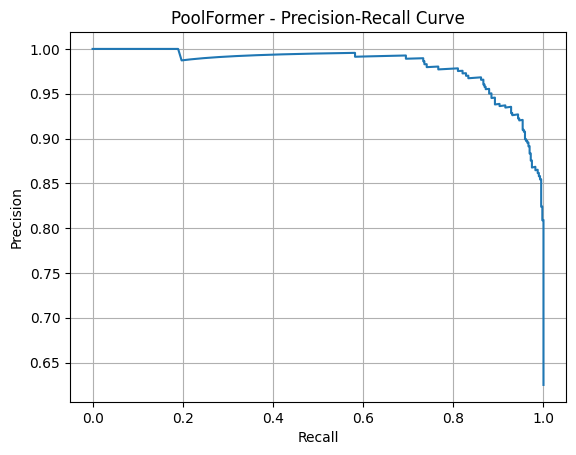

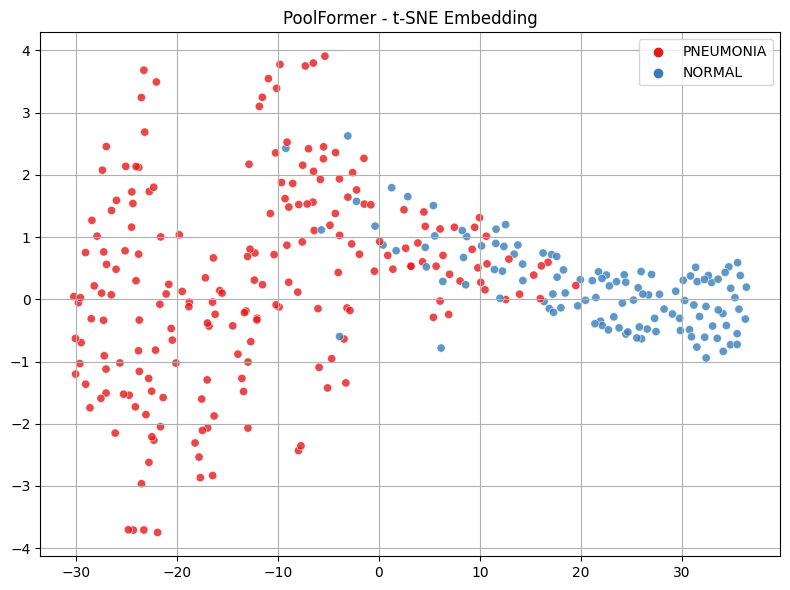

In [52]:
# 1. Load PoolFormer model and processor
poolformer_model = AutoModelForImageClassification.from_pretrained(
    "sail/poolformer_s12",
    num_labels=2,
    ignore_mismatched_sizes=True
)
poolformer_processor = AutoImageProcessor.from_pretrained("sail/poolformer_s12")
poolformer_model = poolformer_model.to(device)

# 2. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(poolformer_model.parameters(), lr=2e-5)

# 3. Training loop
train_losses_pf, val_losses_pf = [], []
for epoch in range(5):
    poolformer_model.train()
    train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = poolformer_model(imgs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    poolformer_model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = poolformer_model(imgs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_losses_pf.append(train_loss / len(train_loader))
    val_losses_pf.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1} - Train Loss: {train_losses_pf[-1]:.4f}, Val Loss: {val_losses_pf[-1]:.4f}")

# 4. Evaluate on test set
poolformer_model.eval()
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = poolformer_model(imgs).logits
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# 5. Metrics and plots
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc_score = roc_auc_score(all_labels, all_probs)

plt.plot(train_losses_pf, label='Train Loss')
plt.plot(val_losses_pf, label='Val Loss')
plt.title("PoolFormer - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("PoolFormer - AUC ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.legend()
plt.show()

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title("PoolFormer - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

prec, rec, _ = precision_recall_curve(all_labels, all_probs)
plt.plot(rec, prec)
plt.title("PoolFormer - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

features = []
tsne_labels = []
with torch.no_grad():
    for i, (imgs, labels) in enumerate(test_loader):
        if len(features) >= 300:
            break
        imgs = imgs.to(device)
        logits = poolformer_model(imgs).logits.cpu().numpy()
        features.extend(logits)
        tsne_labels.extend(labels.numpy())

tsne_result = TSNE(n_components=2, random_state=42).fit_transform(np.array(features))
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                hue=["NORMAL" if i == 0 else "PNEUMONIA" for i in tsne_labels],
                palette="Set1", alpha=0.8)
plt.title("PoolFormer - t-SNE Embedding")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Save to final_results
poolformer_metrics = {
    "Model": "PoolFormer",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC": auc_score
}
final_results = pd.concat([final_results, pd.DataFrame([poolformer_metrics])], ignore_index=True)


In [53]:
final_results

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,ViT Base,0.851000,0.810000,0.994900,0.893000,0.965700
1,Swin Transformer,0.844551,0.803313,0.994872,0.888889,0.976742
2,DeiT,0.833333,0.790650,0.997436,0.882086,0.970321
3,MobileViT,0.863782,0.826552,0.989744,0.900817,0.973099
4,PoolFormer,0.847756,0.804124,1.000000,0.891429,0.972315


/tmp/ipykernel_36/1394367300.py:29: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


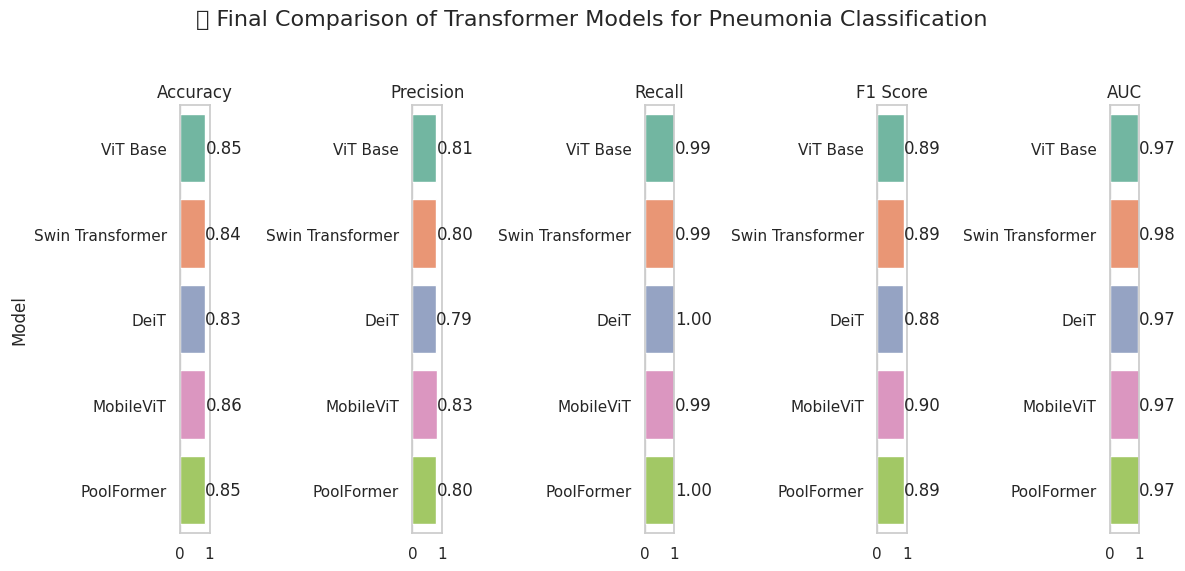

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure metrics are float type
final_results[["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]] = final_results[["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]].astype(float)

# Set plot style
sns.set(style="whitegrid")

# Plot metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    plt.subplot(1, 5, i + 1)
    sns.barplot(data=final_results, x=metric, y="Model", palette="Set2")
    plt.title(metric)
    plt.xlabel("")
    if i == 0:
        plt.ylabel("Model")
    else:
        plt.ylabel("")
    plt.xlim(0, 1)
    for index, row in final_results.iterrows():
        value = row[metric]
        plt.text(value + 0.01, index, f"{value:.2f}", va='center')

plt.suptitle("🔍 Final Comparison of Transformer Models for Pneumonia Classification", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [55]:
# Rank by F1 Score and AUC
final_results_sorted = final_results.sort_values(by=["F1 Score", "AUC"], ascending=False).reset_index(drop=True)
print("🏆 Best Transformer Models by F1 Score and AUC:")
display(final_results_sorted)

# Highlight top 1
best_model = final_results_sorted.iloc[0]
print(f"\n✅ Best Model Overall: {best_model['Model']}")
print(f"  - Accuracy : {best_model['Accuracy']:.4f}")
print(f"  - Precision: {best_model['Precision']:.4f}")
print(f"  - Recall   : {best_model['Recall']:.4f}")
print(f"  - F1 Score : {best_model['F1 Score']:.4f}")
print(f"  - AUC      : {best_model['AUC']:.4f}")


🏆 Best Transformer Models by F1 Score and AUC:


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,MobileViT,0.863782,0.826552,0.989744,0.900817,0.973099
1,ViT Base,0.851000,0.810000,0.994900,0.893000,0.965700
2,PoolFormer,0.847756,0.804124,1.000000,0.891429,0.972315
3,Swin Transformer,0.844551,0.803313,0.994872,0.888889,0.976742
4,DeiT,0.833333,0.790650,0.997436,0.882086,0.970321



✅ Best Model Overall: MobileViT
  - Accuracy : 0.8638
  - Precision: 0.8266
  - Recall   : 0.9897
  - F1 Score : 0.9008
  - AUC      : 0.9731
